<a href="https://colab.research.google.com/github/BakhtawarRehman/Facial-Emotion-Recognition/blob/master/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import keras
#from keras.models import Sequential, Model, model_from_json
from keras.utils import np_utils
#from keras.callbacks import ModelCheckpoint
#from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow import keras
import os
import cv2

%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = '/content/drive/My Drive/fer2013.csv'
data = pd.read_csv(path)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


This dataset is about finding the right emotion. There are seven universal facial emotions (according to many studies; some modern studies might not agree): happy, sad, angry, afraid, surprise,disgust, and neutral

In [0]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [0]:
# Check if there are any null entries
train = data[["emotion", "pixels"]][data["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

In [0]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [0]:
train['pixels'][0]

array([ 70.,  80.,  82., ..., 106., 109.,  82.])

In [0]:
#For validation
public_test_df = data[["emotion", "pixels"]][data["Usage"]=="PublicTest"]

public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_val = np.vstack(public_test_df["pixels"].values)
y_val = np.array(public_test_df["emotion"])

x_val.shape, y_val.shape

((3589, 2304), (3589,))

In [0]:
#Data in usable format
x_train = x_train.reshape(-1, 48, 48, 1)
x_val = x_val.reshape(-1, 48, 48, 1)
x_train.shape, x_val.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [0]:
x_train[2870].shape

(48, 48, 1)

In [0]:
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_train.shape, y_val.shape

((28709, 7), (3589, 7))

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<function matplotlib.pyplot.show>

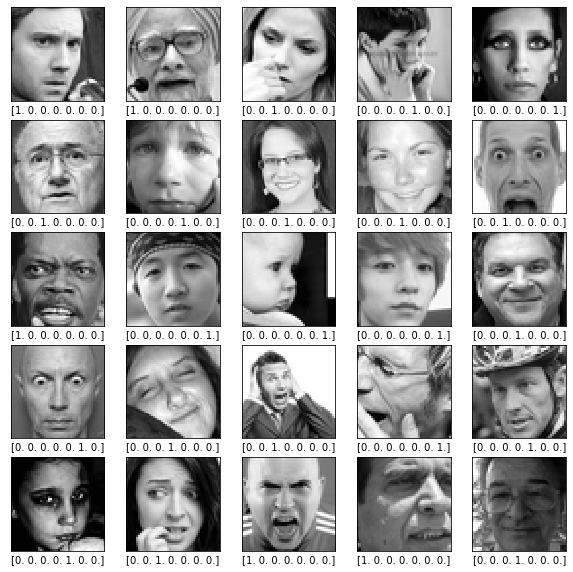

In [0]:
#Here we are going to display the data
# TO See how it looks like
# Earlier we re-format the data and each image dimension = (48,48,1)
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # matplot lib's plt need this to be squeezed into (48,48); otherwise it will show an error.
    plt.imshow(np.squeeze(x_train[i]), cmap='gray')
    plt.xlabel(y_train[i])
plt.show

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 60
height = 48 
width =48

A NN with a couple of convolutional and maxpooling layers. This gives an idea on the amount of accuracy we can strive to acheive and efforts we should put in pre-processing. 

In [0]:
model0 = keras.Sequential ([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(height, width,1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='sigmoid')
])

In [0]:
model0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [0]:
#model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),metrics=['accuracy'])
model0.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model0.fit(x_train, y_train, batch_size=batch_size, epochs=10, verbose=1, validation_data=(x_val, y_val), shuffle=True)

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
28709/28709 [==============================] - 3s 99us/sample - loss: 11.3752 - accuracy: 0.1392 - val_loss: 11.3045 - val_accuracy: 0.1301
Epoch 2/10
28709/28709 [==============================] - 3s 101us/sample - loss: 11.3752 - accuracy: 0.1392 - val_loss: 11.3045 - val_accuracy: 0.1301
Epoch 3/10
28709/28709 [==============================] - 3s 100us/sample - loss: 11.3752 - accuracy: 0.1392 - val_loss: 11.3045 - val_accuracy: 0.1301
Epoch 4/10
28709/28709 [==============================] - 3s 101us/sample - loss: 11.3752 - accuracy: 0.1392 - val_loss: 11.3045 - val_accuracy: 0.1301
Epoch 5/10
28709/28709 [==============================] - 3s 101us/sample - loss: 11.3752 - accuracy: 0.1392 - val_loss: 11.3045 - val_accuracy: 0.1301
Epoch 6/10
28709/28709 [==============================] - 3s 102us/sample - loss: 11.3752 - accuracy: 0.1392 - val_loss: 11.3045 - val_accuracy: 0.1301
Epoch 7/10
28709/28709 [================

In [0]:
#Let's c if we can have some impact with augmentation
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.1, zoom_range=0.1,
                         horizontal_flip=True, fill_mode="nearest")

In [0]:
# run model
hist = model0.fit_generator( aug.flow(x_train, y_train, batch_size=batch_size), epochs=10,
                 shuffle=True,
                 steps_per_epoch=len(x_train) // batch_size,
                 validation_data=(x_val, y_val),
                 verbose=1)

Epoch 1/10
448/448 [==============================] - 22s 49ms/step - loss: 11.3776 - accuracy: 0.1390 - val_loss: 11.1828 - val_accuracy: 0.1301
Epoch 2/10
448/448 [==============================] - 22s 48ms/step - loss: 11.3718 - accuracy: 0.1393 - val_loss: 11.1827 - val_accuracy: 0.1301
Epoch 3/10
448/448 [==============================] - 22s 48ms/step - loss: 11.3774 - accuracy: 0.1389 - val_loss: 11.1827 - val_accuracy: 0.1301
Epoch 4/10
448/448 [==============================] - 22s 50ms/step - loss: 11.3665 - accuracy: 0.1395 - val_loss: 11.1828 - val_accuracy: 0.1301
Epoch 5/10
448/448 [==============================] - 23s 51ms/step - loss: 11.3716 - accuracy: 0.1396 - val_loss: 11.1828 - val_accuracy: 0.1301
Epoch 6/10
448/448 [==============================] - 23s 51ms/step - loss: 11.3905 - accuracy: 0.1387 - val_loss: 11.1828 - val_accuracy: 0.1301
Epoch 7/10
448/448 [==============================] - 22s 48ms/step - loss: 11.3628 - accuracy: 0.1394 - val_loss: 11.1828 -

Let's use apopular approach to tackle the proble. This network design is inspired from an online article with a little bit of tweaking.


In [0]:
model = keras.Sequential ([
    keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    keras.layers.Conv2D(num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    #keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(2*2*2*num_features, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2*2*num_features, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(2*num_features, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(7, activation='softmax')
])

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_val, y_val), shuffle=True)

Train on 28709 samples, validate on 3589 samples
Epoch 1/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.8040 - accuracy: 0.2563 - val_loss: 1.7433 - val_accuracy: 0.2940
Epoch 2/60
28709/28709 [==============================] - 19s 653us/sample - loss: 1.7113 - accuracy: 0.3054 - val_loss: 1.6352 - val_accuracy: 0.3527
Epoch 3/60
28709/28709 [==============================] - 19s 653us/sample - loss: 1.6083 - accuracy: 0.3548 - val_loss: 1.5607 - val_accuracy: 0.3809
Epoch 4/60
28709/28709 [==============================] - 19s 654us/sample - loss: 1.5195 - accuracy: 0.3973 - val_loss: 1.5285 - val_accuracy: 0.4096
Epoch 5/60
28709/28709 [==============================] - 19s 653us/sample - loss: 1.4547 - accuracy: 0.4297 - val_loss: 1.4185 - val_accuracy: 0.4645
Epoch 6/60
28709/28709 [==============================] - 19s 656us/sample - loss: 1.4089 - accuracy: 0.4558 - val_loss: 1.3243 - val_accuracy: 0.4870
Epoch 7/60
28709/28709 [=====================

#Now preprocessing for Transfer Learning.
Networks like resnet, densenet, vgg etc are trained on rgb image. Fer is a gray scale image they expect a 3dimenional image and usually in a greater size. Increasing size of the image might lead to decreased accuracy but this is the trade-odd we will have to bear with this dataset.

In [0]:
#Making photos 3-dimensional.
print ('before the shape is {}'.format(x_train.shape))
tChannel = np.squeeze(x_train)
tChannel = np.repeat(tChannel[..., np.newaxis],3,-1)
print ('After the shape is {}'.format(tChannel.shape))

'''
#TF's method to decrease overall size. 
sI=tf.image.grayscale_to_rgb(
    tf.convert_to_tensor(x_train),
    name=None
)
'''
#############################################
#valiation set to 3-dimensions
#Making photos 3-dimensional.
print ('before the shape is {}'.format(x_val.shape))
tVal = np.squeeze(x_val)
tVal = np.repeat(tVal[..., np.newaxis],3,-1)
print ('After the shape is {}'.format(tVal.shape))


before the shape is (28709, 48, 48, 1)
After the shape is (28709, 48, 48, 3)
before the shape is (3589, 48, 48, 1)
After the shape is (3589, 48, 48, 3)


In [0]:
img_height, img_width = 96, 96
from skimage.transform import resize
nBatch = tf.image.resize(tChannel, [img_height, img_width])
print('nBatch size is: {}'.format(nBatch.shape))
####################################
#resizing the validation set below
nValBatch = tf.image.resize(tVal, [img_height, img_width])
print('nValBatch size is: {}'.format(nValBatch.shape))

nBatch size is: (28709, 96, 96, 3)
nValBatch size is: (3589, 96, 96, 3)


NOW, THAT THE DATA HAS BEEN PROCESSED.
*****  USING INCEPTION-V3 FOR THIS NN  ****

In [0]:
local_weights_file = "/content/drive/My Drive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (96, 96, 3), 
                                include_top = False, 
                                weights = 'imagenet')

pre_trained_model.load_weights(local_weights_file)

In [0]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [0]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 768)


In [0]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)
# Add BatchNormalization Layer
x = tf.keras.layers.BatchNormalization()(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)     

x = tf.keras.layers.Dense(124, activation='relu')(x)

# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (7, activation='softmax')(x)           

model = tf.keras.models.Model( pre_trained_model.input, x) 

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])



In [0]:
model.fit(nBatch, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(nValBatch, y_val), shuffle=True)

Train on 28709 samples, validate on 3589 samples
Epoch 1/60
28709/28709 [==============================] - 19s 665us/sample - loss: 1.5124 - acc: 0.4323 - val_loss: 17.1534 - val_acc: 0.1719
Epoch 2/60
28709/28709 [==============================] - 14s 474us/sample - loss: 1.2051 - acc: 0.5470 - val_loss: 26.4635 - val_acc: 0.1800
Epoch 3/60
28709/28709 [==============================] - 14s 474us/sample - loss: 1.0489 - acc: 0.6077 - val_loss: 23.8367 - val_acc: 0.1741
Epoch 4/60
28709/28709 [==============================] - 14s 475us/sample - loss: 0.9052 - acc: 0.6639 - val_loss: 30.2976 - val_acc: 0.2329
Epoch 5/60
28709/28709 [==============================] - 14s 474us/sample - loss: 0.7646 - acc: 0.7225 - val_loss: 38.7773 - val_acc: 0.2235
Epoch 6/60
28709/28709 [==============================] - 14s 475us/sample - loss: 0.6654 - acc: 0.7571 - val_loss: 74.4481 - val_acc: 0.1694
Epoch 7/60
28709/28709 [==============================] - 14s 473us/sample - loss: 0.5670 - acc: 0.

Above, Received **95%** accuracy on training set but only **25%** is the maximum score reached on the validation dataset. Let'stry to improve the performance on validation set.



In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   #shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')



###############
test_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   #shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')


In [0]:
model.compile(optimizer = Adam(lr = 1e-3, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.0),
              #tf.keras.optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=1e-06), 
              loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [0]:
# run model
hist = model.fit_generator( train_datagen.flow(nBatch, y_train, batch_size=batch_size), epochs=epochs,
                 shuffle=True,
                 steps_per_epoch=len(x_train) // batch_size,
                 
                 validation_data=test_datagen.flow(nValBatch, y_val),
                 verbose=1)

Epoch 1/60
448/448 [==============================] - 141s 315ms/step - loss: 1.3900 - acc: 0.4730 - val_loss: 3.7820 - val_acc: 0.3318
Epoch 2/60
448/448 [==============================] - 141s 315ms/step - loss: 1.3581 - acc: 0.4831 - val_loss: 4.3436 - val_acc: 0.3227
Epoch 3/60
448/448 [==============================] - 142s 316ms/step - loss: 1.3439 - acc: 0.4865 - val_loss: 5.0601 - val_acc: 0.3040
Epoch 4/60
448/448 [==============================] - 141s 314ms/step - loss: 1.3187 - acc: 0.4984 - val_loss: 3.1083 - val_acc: 0.3580
Epoch 5/60
448/448 [==============================] - 139s 311ms/step - loss: 1.3095 - acc: 0.5007 - val_loss: 2.9527 - val_acc: 0.3569
Epoch 6/60
448/448 [==============================] - 139s 311ms/step - loss: 1.2979 - acc: 0.5088 - val_loss: 3.4518 - val_acc: 0.3441
Epoch 7/60
448/448 [==============================] - 138s 309ms/step - loss: 1.2924 - acc: 0.5081 - val_loss: 3.8297 - val_acc: 0.3146
Epoch 8/60
448/448 [============================

THINGS TO REMEMBER BASED ONLY ON THIS WORK DONE (NOT CONSIDERING OTHER STUDIES N EXPERIENCE; This help to pick up pieces more quickly):

-- It is a competetive dataset. It was released in 2013 and still the highest performing algorithms are somewhere around 70.

-- BatchNormalization may improve performance even after flattening.

-- (Transfer Learning) Converting greyscale images to 3Dims and increasing resolution is going to hit you really bad. Next time try to use other approaches e.g:


1.   consider retraining the 1st layer. Again, not recommended but some people find it to be useful.
2. Consider retraining the network and compare the performance)
3. SPATIAL Transformer is very next thing you need to implement.


